<a href="https://colab.research.google.com/github/KordingLab/Neural_Decoding/blob/classifiers/central_concepts_in_ML_for_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding neural activity
_Machine learning for mind reading_

This tutorial introduces concepts that are central to the practice of decoding neural activity using machine learning (or any method). We will make heavy use of our [Python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

This tutorial accompanies these [lecture slides](https://).

The solutions to the exercises can be found in [this completed Colab](https://colab.research.google.com/drive/1SxXwmTgW2Ro34BQEy91zOXHs9JhMqcBJ).

### Outline

1. Overfitting
2. Crossvalidation
3. Regularization
4. Applying recurrent neural networks
5. What methods work best and when?

## Preliminaries

Import modules and simulate data

In [88]:
import numpy as np
from matplotlib import pyplot as plt

### Let's simulate some data

In [89]:
# Generate some fake trial data
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

In [90]:
# And generate some fake neural recordings
# We'll pretend we have a drift diffusion model

def generate_neural_data(n_trials, n_neurons = 25, n_bins_per_trial = 50,
                         noise_variance = 1, drift_rate = 0.07,
                         mean_rate = 25):
    '''Generates fake neural data of shape (n_trials, n_neurons, n_bins_per_trial
        according to a drift diffusion process with given parameters.
     Also generates decisions, which is 0 or 1 depending on the "animal's decision"
        and is returned as an array of shape (n_trials,) 
        
    Returns: (neural_data, decisions)
    '''

    decisions = np.random.binomial(1,.5,size = n_trials)
  
    neural_recordings = np.zeros((n_trials,n_neurons,n_bins_per_trial))

    for t in range(n_bins_per_trial):
        if t==0:
            neural_recordings[:,:,t] = mean_rate + np.random.randn(n_trials,n_neurons) * noise_variance
        else:
            neural_recordings[:,:,t] = neural_recordings[:,:,t-1] \
                      + np.reshape(drift_rate*(decisions*2-1),(len(decisions),1)) \
                      + np.random.randn(n_trials,n_neurons) * noise_variance
      
    return neural_recordings, decisions

neural_recordings, decisions = generate_neural_data(n_trials, 
                                         n_neurons, n_bins_per_trial)

In [91]:
len(decisions)

250

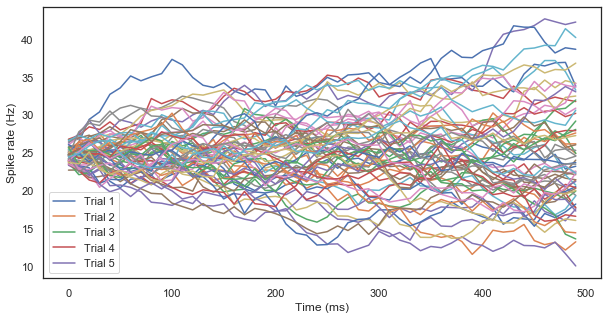

In [92]:
# plot out some trials for one neuron

neuron_id = 4

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:60,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

## Exercise 0

#### Exercise 0: Look at the distribution of neural activity 

Let's gain an intuition for the data. Plot out the average neural activity for each of the two choices. 

Average across trials **and** neurons — we're going to assume they have the same response properties. Then, plot out the averages for trials with a choices of 0 vs a choice of 1.

If you have extra time, overlay the standard deviations.

In [93]:
neural_recordings.shape

(250, 10, 50)

In [94]:
average_dec0 = np.mean(np.mean(neural_recordings[decisions == 0,:,:], axis=0), axis=0)
std_dec0     = np.std(np.mean(neural_recordings[decisions == 0,:,:], axis=0), axis=0)
average_dec1 = np.mean(np.mean(neural_recordings[decisions == 1,:,:], axis=0), axis=0)
std_dec1     = np.std(np.mean(neural_recordings[decisions == 1,:,:], axis=0), axis=0)

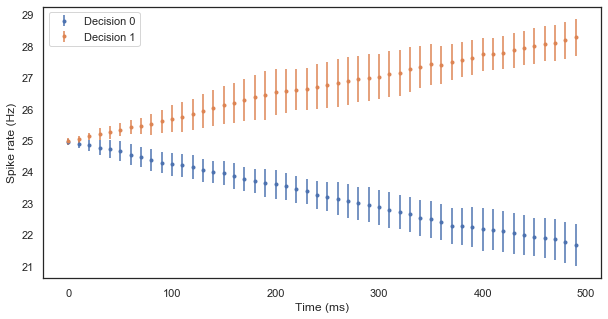

In [95]:
plt.figure(figsize=(10,5))
#plt.plot(np.arange(0,500,10),average_dec1)
plt.errorbar(np.arange(0,500,10), average_dec0, std_dec0, linestyle='None', marker='.', label='Decision 0')
plt.errorbar(np.arange(0,500,10), average_dec1, std_dec1, linestyle='None', marker='.', label='Decision 1')
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(loc='upper left')

## 1. Overfitting

<img src='https://cdn-images-1.medium.com/max/1600/1*SBUK2QEfCP-zvJmKm14wGQ.png' />

In common parlance, we call a classifier or regressor 'overfit' when it has learned to explain noise in the training set at the expense of its ability to generalize to new data.

In that one-sentence description, we invoked the concepts of _training set_ and _generalization_. These are absolutely key to any modeling effort, including decoding.

##### Training sets vs. testing sets
You need to train your decoder, obviously, and for that you'll need training data. No one cares how well your decoder works on your training data, though. What we care about is its _performance on data not used for training_.  That is, we are interested in how well your decoder **generalizes** to new data. The only way to rigorously know how well your decoder generalizes is to test it on data not used for training. 

In [96]:
import seaborn as sns
sns.set(style='white')

In [97]:
from sklearn import linear_model

In [98]:
## Fit a decoder using all your data

# We'll predict each decision using all neurons's activity throughout the trials
X = np.reshape(neural_recordings, (n_trials,-1))

# initalize the model
my_naive_model = linear_model.LinearRegression()

#fit
my_naive_model.fit(X, decisions)

# And see how we did on our data set,
print("R2 was",my_naive_model.score(X,decisions))

R2 was 1.0


In [99]:
X.shape

(250, 500)

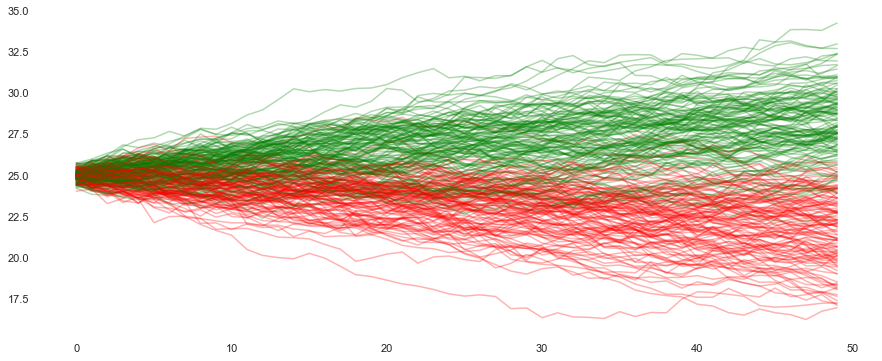

In [100]:
figure = plt.figure(figsize=(15,6))
ax = figure.add_subplot(111)
for trial in range(X.shape[0]):
    ax.plot(np.mean(X[trial,:].reshape((n_neurons,-1)),axis=0), c=['red' if not decisions[trial] else 'green'][0], alpha=.3)

sns.despine(left=True,bottom=True)

**Looks great!** 

#### Exercise 1.1: 
Now, suppose you release your decoder in the world. Will it work? Can't be better than perfect, right?

Create some new data and use the `score` function to see the $R^2$ of your model on new data.

In [101]:
# Let's do new electrophysiology and take new data. This cost $2,000,000 in 
# NIH funding so it better work.
new_neural_recordings, new_decisions = generate_neural_data(n_trials, 
                                             n_neurons, n_bins_per_trial)
new_X = np.reshape(new_neural_recordings, (n_trials,-1))


# Now you: score the model on this new data
my_naive_model.score(new_X, new_decisions)

0.3583780446279863

#### Exercise 1.2: 
You may have noticed that we're using linear *regression*, even though we have a classification problem.
It'd be better to use logistic regression. 

Fit and score this logistic regression method using your original data.

Then, also score this method with the new data you just obtained with your R01 funds. (That is, print both the test and train accuracy.)

In [114]:
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)

# fit
log_reg.fit(X, decisions)
# now score on both test and train
print(f'R^2 of train: {log_reg.score(X,decisions)} R^2 of test: {log_reg.score(new_X, new_decisions)}')

R^2 of train: 1.0 R^2 of test: 0.916


Once you've completed that, just run this next cell. 

It shows the coefficients of the fit you just made. Does it match your intuitions? 

In [103]:
#n_trials = 250
#n_neurons = 10
#n_bins_per_trial = 50

In [115]:
log_reg.coef_.reshape(n_neurons, n_bins_per_trial).shape

(10, 50)

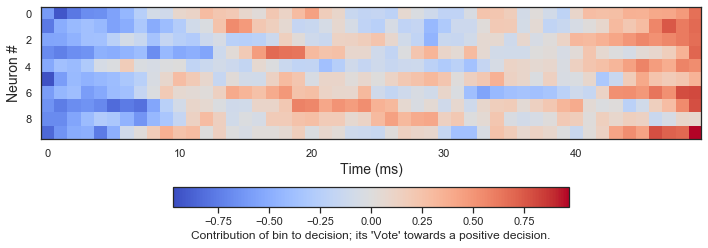

In [116]:
def plot_coefs(fit_model):
    """Makes a nice plot of the coefficients. fit_model is the model instance after fitting."""
    # get the coefficients of your fit
    coefficients = fit_model.coef_.reshape(n_neurons, n_bins_per_trial)

    # show them
    plt.figure(figsize = (10,5))
    plt.imshow(coefficients, cmap = 'coolwarm', vmin = -np.max(coefficients), 
                                                 vmax = np.max(coefficients))
    #make it pretty
    plt.ylabel("Neuron #", fontsize = 14)
    plt.xlabel("Time (ms)", fontsize = 14)
    plt.colorbar(orientation = 'horizontal', shrink = .6, 
                        label="Contribution of bin to decision; its 'Vote' towards a positive decision.")
    plt.tight_layout()
    plt.show()

plot_coefs(log_reg)

## 2. Crossvalidation

We saw in the last section that if we used all of our training data to fit a method, we have no idea how our method will work 
on new data. This a problem for any engineering purpose.

We also have no idea if our coefficients are meaningful or reflect random noise in the data. This is a problem for the science.

The way to address this problem is to **split your data into a training segment and a validation segment**. We'll try an 80%/20% split.

In [122]:
split = int(n_trials*4/5)
split

200

In [107]:
training_data = X[:split,:]
validation_data = X[split:,:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

In [140]:
training_data.shape

(200, 500)

In [127]:
# fit on the training data. (Don't forget to reinitialize your decoder first.)
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 10000)


# fit and score on training
log_reg.fit(training_data,training_decisions)
score_validation = log_reg.score(validation_data,validation_decisions)
print('Score: {:.2f}'.format(score_validation))

Score: 0.94


In [124]:
# score on the validation data

But right now we're only testing on 20% of the data! Small data means high variance, so maybe we can't trust these scores much.

A common practice is therefore to perform __k-fold crossvalidation__. This just means we rotate which segment of the original data is the validation set. We can then average the scores.

In [143]:
# Just run this.
def get_test_train_splits(data, decisions, n_folds=5):
    """
    Returns a tuple of matched train sets and validation sets, rotating through the data.
    Note that there are scikit-learn functions that do this, too."""

    fold_size = len(data)//n_folds
    print(fold_size)
    training_sets = [np.roll(data,fold_size*i,axis=0)[fold_size:,:] for i in range(n_folds)]
    val_sets = [np.roll(data,fold_size*i,axis=0)[:fold_size,:] for i in range(n_folds)]

    training_Y = [np.roll(decisions,fold_size*i)[fold_size:] for i in range(n_folds)]
    val_Y = [np.roll(decisions,fold_size*i)[:fold_size] for i in range(n_folds)]

    return (training_sets, training_Y), (val_sets, val_Y)

#### Excercise 2

Fill out the missing gaps in the script below. 


In [146]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []
# Iterate through the k=5 folds
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    # Redefine the logistic regression model. (important to do this inside the loop)
    log_reg = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                          max_iter = 10000)

    # Now fit on the training data
    this_model.fit(training_X,training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X,validation_Y)

    scores.append(this_accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = this_model.score(new_X,new_decisions)

    print("   Validation accuracy of {}".format( this_accuracy ))
    print("   True test set accuracy of {}".format( accuracy_on_test_data ))
    #plot_coefs(this_model)

print("Mean validation accuracy: {}".format(np.mean(scores)))

50
Fold 0 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.904
Fold 1 of 5
   Validation accuracy of 0.94
   True test set accuracy of 0.916
Fold 2 of 5
   Validation accuracy of 0.94
   True test set accuracy of 0.928
Fold 3 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.908
Fold 4 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.92
Mean validation accuracy: 0.9279999999999999


How close is the validation accuracy to the test set accuracy? 

How much did using 80% of the data affect the test set accuracy?

## 3. Regularization

Here we'll apply regularization, as talked about in the lecture.


#### Exercise 3.1

Go to the [scikit-learn docs](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) and decide which form of regularization you would like to use with logistic regression.

#### Exercise 3.2

Copy and paste the cell from _Excercise 2_, but this time change the `penalty` flag in the `LogisticRegression` call to the form of regularization you chose. 


First all other default parameters. Then set `C=1e-6` and see what happens.


In [149]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    # Redefine the logistic regression model. (important to do this inside the loop)
    this_model = linear_model.LogisticRegression(penalty='l2', solver='sag',
                                          max_iter = 1000)

    # Now fit on the training data
    this_model.fit(training_X,training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X,validation_Y)

    scores.append(this_accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = this_model.score(new_X,new_decisions)

    print("   Validation accuracy of {}".format( this_accuracy ))
    print("   True test set accuracy of {}".format( accuracy_on_test_data ))

print("\n\nMean validation accuracy: {}\n\n".format(np.mean(scores)))

50
Fold 0 of 5
   Validation accuracy of 0.96
   True test set accuracy of 0.916
Fold 1 of 5
   Validation accuracy of 0.96
   True test set accuracy of 0.932
Fold 2 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.944
Fold 3 of 5
   Validation accuracy of 0.9
   True test set accuracy of 0.92
Fold 4 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.916


Mean validation accuracy: 0.932




#### Exercise 3.3: Choose the best regularization penalty

Let's automate the above process so that we can choose the best performing value of `C`.

First, write a function (largely copy and paste from the last exercise) that returns the mean validation accuracy for
an arbitrary value of `C`.

In [150]:
# First complete this function that takes data (e.g. X) 
# and a model, and returns the average validation accuracy from 5-fold CV
# (Largely copy and past from above, but deleting print statements)
def get_kfold_validation_score(data, decisions, C):

    (training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(data, decisions)

    scores = []

    # Iterate through the k=5 folds
    for fold in range(5):
        training_X = training_sets[fold]
        training_Y = training_Ys[fold]

        validation_X = val_sets[fold]
        validation_Y = val_Ys[fold]

        # Redefine the logistic regression model. (important to do this inside the loop)
        this_model = linear_model.LogisticRegression(penalty='l2', solver='lbfgs',
                                                          max_iter = 10000, C=C)

        # Now fit on the training data
        this_model.fit(training_X,training_Y)

        # score on the validation data
        this_accuracy = this_model.score(validation_X,validation_Y)

        scores.append(this_accuracy)

        # score on the new dataset (new_X, new_decisions from above)
        accuracy_on_test_data = this_model.score(new_X,new_decisions)
        
    mean_validation_accuracy = np.mean(scores)
    print("Mean validation accuracy: {}".format(mean_validation_accuracy))

    return mean_validation_accuracy

Now let's create a loop for various values of `C` and see what's the best.


In [151]:
# decide on a logarithmic schedule of Cs. 
Cs_to_test = [1/(10**x) for x in range(10)]

validation_accuracy_vs_C = []
for C in Cs_to_test: 
    # get the mean score on k-fold cross-validation using your function above
    mean_validation_accuracy = get_kfold_validation_score(X, decisions, C)

    validation_accuracy_vs_C.append(mean_validation_accuracy)



50
Mean validation accuracy: 0.9400000000000001
50
Mean validation accuracy: 0.932
50
Mean validation accuracy: 0.932
50
Mean validation accuracy: 0.932
50
Mean validation accuracy: 0.9199999999999999
50
Mean validation accuracy: 0.9279999999999999
50
Mean validation accuracy: 0.868
50
Mean validation accuracy: 0.612
50
Mean validation accuracy: 0.52
50
Mean validation accuracy: 0.52


Text(0, 0.5, 'validation acc.')

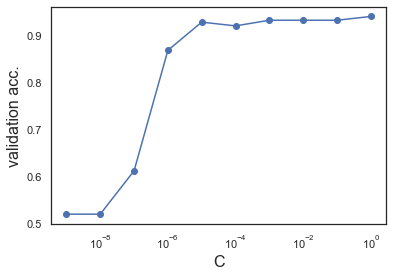

In [153]:
# Now plot the lists you just made. (Just run this.)
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
#plt.ylim([.8,1])

## 4. Applying recurrent neural networks

This section is going to be a bit of an introduction to our [python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

First let's install the package. This will also install all the dependencies we need.

In [154]:
from Neural_Decoding import decoders

import warnings
warnings.filterwarnings('ignore')

Let's take a look at the documentation of the decoder we'll use.

In [ ]:
decoders.NaiveBayesRegression

In [155]:
# Run me
?decoders.SimpleRNNClassification

Init signature:
decoders.SimpleRNNClassification(
    units=400,
    dropout=0,
    num_epochs=10,
    verbose=0,
)
Docstring:     
Class for the RNN decoder

Parameters
----------
units: integer, optional, default 400
    Number of hidden units in each layer

dropout: decimal, optional, default 0
    Proportion of units that get dropped out

num_epochs: integer, optional, default 10
    Number of epochs used for training

verbose: binary, optional, default=0
    Whether to show progress of the fit after each epoch
File:           ~/Documents/python/Neural_Decoding/Neural_Decoding/decoders.py
Type:           type
Subclasses:     


In [156]:
?decoders.SimpleRNNClassification.fit

Signature: decoders.SimpleRNNClassification.fit(self, X_train, y_train)
Docstring:
Train GRU Decoder

Parameters
----------
X_train: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
    This is the neural data.
    See example file for an example of how to format the neural data correctly

y_train: numpy 2d array of shape [n_samples, n_outputs]
    This is the outputs that are being predicted
File:      ~/Documents/python/Neural_Decoding/Neural_Decoding/decoders.py
Type:      function


You'll notice that the shape of the training inputs is now **3-dimensional**. This is because we can now explitly model the effect of time! Hooray! 

Recall that recurrent neural networks contain a "hidden state". The way this decoder works is that it reads all the neural activities in at the first time bin (out of `n_time_bins`) and then updates its hidden state accordingly. The value of this hidden state informs how the hidden state will evolve over time in each trial. After the hidden state updates `n_time_bin` times, it outputs its prediction for the animal's choice.


Lets apply this classifier to the data.

In [157]:
neural_recordings.shape

(250, 10, 50)

In [173]:
# lets re-split our original 3-dimensional trials/neurons/time input data.
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


Training input data is of shape (200, 10, 50)
Validation input data is of shape (50, 10, 50)


In [174]:
# Change axes 
training_data = np.moveaxis(training_data, 1, -1)
validation_data = np.moveaxis(validation_data, 1, -1)

In [176]:

# first we instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [177]:
# now we fit to our training data, like before
my_RNN_classifier.fit(training_data, training_decisions)

Epoch 1/250
200/200 [==============================] - 0s 1ms/step - loss: 0.9563 - accuracy: 0.4950
Epoch 2/250
200/200 [==============================] - 0s 412us/step - loss: 0.7636 - accuracy: 0.4900
Epoch 3/250
200/200 [==============================] - 0s 393us/step - loss: 0.7112 - accuracy: 0.4800
Epoch 4/250
200/200 [==============================] - 0s 443us/step - loss: 0.6820 - accuracy: 0.4800
Epoch 5/250
200/200 [==============================] - 0s 414us/step - loss: 0.6689 - accuracy: 0.5600
Epoch 6/250
200/200 [==============================] - 0s 423us/step - loss: 0.6576 - accuracy: 0.6350
Epoch 7/250
200/200 [==============================] - 0s 404us/step - loss: 0.6545 - accuracy: 0.6600
Epoch 8/250
200/200 [==============================] - 0s 398us/step - loss: 0.6482 - accuracy: 0.6750
Epoch 9/250
200/200 [==============================] - 0s 400us/step - loss: 0.6437 - accuracy: 0.6350
Epoch 10/250
200/200 [==============================] - 0s 414us/step - los

In [178]:
# predict on the validation data

predictions = my_RNN_classifier.predict(validation_data)
predictions

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0])

##### Excercise 4.0

Get the percentage of the predictions that were made correctly.

In [180]:
np.sum(validation_decisions == predictions)/ len(predictions)

0.74

This is not as quite as good as logistic regression yet. There are a lot of parameters to choose for RNNs, and we haven't tried that yet.


#### Looking inside the model

Within the `my_RNN_classifier` object you just fit, there is an actual Keras model. We can look at it, change its parameters, and use Keras methods.

In [81]:
# Put the cursor after model, and press tab to see the methods we can call
my_RNN_classifier.model.

In [181]:
# for example, we can use Keras's in-built method for calculating accuracy
from keras.utils import np_utils
acc = my_RNN_classifier.model.test_on_batch(validation_data, 
                                      np_utils.to_categorical(validation_decisions))
print("Accuracy is {} %".format(100*acc[1]))

Accuracy is 94.40000057220459 %


#### Excercise 4.1: Tuning the RNN

Train an RNN decoder again, but this time use 1000 hidden units instead of 50.

In [182]:
# first we instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units =1000,
                                                      dropout = 0,
                                                      num_epochs = 250,
                                                      verbose = 0)
# now we fit to our training data, like before
my_RNN_classifier.fit(training_data, training_decisions)
acc = my_RNN_classifier.model.test_on_batch(validation_data, 
                                      np_utils.to_categorical(validation_decisions))
print("Accuracy is {} %".format(100*acc[1]))

Accuracy is 99.59999918937683 %


## 5. Compare many methods on actual neural data

### Preliminaries

**STOP** Make sure you're running a **GPU runtime** for this section. (Runtime -> Change runtime type). Otherwise running the RNNs will take forever.

First we need to download the data. I created a script to download and process the Steinmetz data into the format we need. Since the processing script takes about 15 minutes, we'll skip that step, and you can just download the processed data from my Google Drive.

This dataset is specifically `Cori_2016-12-18`. If you're interested in loading a different session, I've copied my downloading and preprocessing script in the bottom of this notebook and you can run it right here.

In [250]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1

In [251]:
binned_spikes.shape

(228, 1089, 50)

In [252]:
len(choices)

228

In [253]:
binned_spikes[0,0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

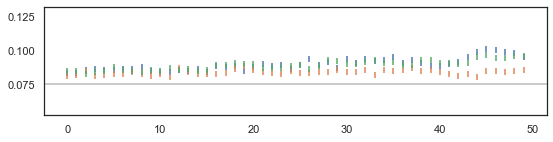

In [254]:
# Plot some examples
figure = plt.figure(figsize=(9,2))
ax = figure.add_subplot(111)
ax.scatter(np.arange(binned_spikes.shape[2]),np.mean(np.mean(binned_spikes[choices==2,:,:],axis=0),axis=0),marker='|')
ax.axhline(y=0.075,c='k',alpha=.3)
ax.scatter(np.arange(binned_spikes.shape[2]),np.mean(np.mean(binned_spikes[choices==1,:,:],axis=0),axis=0),marker='|')
ax.scatter(np.arange(binned_spikes.shape[2]),np.mean(np.mean(binned_spikes[choices==0,:,:],axis=0),axis=0),marker='|')

### Predicting choices from neural population recordings

We're going to try to predict the mouse's choices from the neuropixel recordings in the 1 second preceeding each choice. `binned_spikes.npy` is a numpy array containing the binned spike rates, and `choices.npy` contains the animal's choices. 

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).

This is not a great situation for machine learning. As a rule of thumb, we would like more trials than datapoints per trial. (If doing this for realz, would suggest running PCA on this data and using the top components as inputs). But, it's what we got, so here goes!

#### Exercise 5.0

Print out the shape of `binned_spikes` and `choices`. Also print out the first 10 choices.



In [263]:
print(binned_spikes.shape, choices.shape)
print(choices[:10])

# Need to rearrange array since format is wrong 
binned_spikes = np.moveaxis(binned_spikes, 1, -1)

(228, 1089, 50) (228,)
[2. 2. 0. 0. 0. 1. 0. 0. 0. 2.]


You'll notice that `choices` takes values 0, 1, and 2. We're going to try to decode this.

#### Excercise 5.1

Split this data into test and validation splits.

(We'll skip the final testing phase in this exercise. In reality, make sure to do cross-validation and use both validation and testing data.)

In [264]:
# make training and validation data
# Use an 80/20 split.|
split = int(binned_spikes.shape[0]*4/5)


training_spikes = binned_spikes[:split,:,:]
validation_spikes = binned_spikes[split:,:,:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [265]:
training_spikes.shape

(182, 50, 1089)

##### A fitting demo.

This is basically what we did above, but with actual data.

In [403]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 500,
                                                     dropout = 10,
                                                     num_epochs = 50,
                                                     verbose = 0)

my_RNN_classifier.fit(training_spikes, training_choices)

predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


 validation accuracy: 67.3913043478261 %


Note that the train accuracy reached about 100% in these 10 epochs, but the validation accuracy is quite low. Sounds like overfitting! We might want to try some regularization, like dropout.

### Excercise 5.1

Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)





In [268]:
# GRU
my_gru_classifier = decoders.GRUClassification(units = 500,
                                                 dropout = 5,
                                                 num_epochs = 10,
                                                 verbose = 1)

my_gru_classifier.fit(training_spikes, training_choices)

predictions = my_gru_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))

Epoch 1/10
182/182 [==============================] - 3s 18ms/step - loss: 1.1397 - accuracy: 0.4505
Epoch 2/10
182/182 [==============================] - 3s 15ms/step - loss: 0.5376 - accuracy: 0.8187
Epoch 3/10
182/182 [==============================] - 3s 15ms/step - loss: 0.2968 - accuracy: 0.8791
Epoch 4/10
182/182 [==============================] - 3s 15ms/step - loss: 0.0586 - accuracy: 1.0000
Epoch 5/10
182/182 [==============================] - 3s 15ms/step - loss: 0.0194 - accuracy: 1.0000
Epoch 6/10
182/182 [==============================] - 3s 15ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 7/10
182/182 [==============================] - 3s 16ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 8/10
182/182 [==============================] - 3s 15ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 9/10
182/182 [==============================] - 3s 15ms/step - loss: 6.9450e-04 - accuracy: 1.0000
Epoch 10/10
182/182 [==============================] - 3s 15ms/step - loss: 0.1953 - ac

In [406]:
#LSTM
my_lstm_classifier = decoders.LSTMClassification(units = 500,
                             dropout = 10,
                             num_epochs = 50,
                             verbose = 0)
my_lstm_classifier.fit(training_spikes, training_choices)
predictions = my_lstm_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


 validation accuracy: 82.6086956521739 %


In [439]:
# XGBoost

# XGBoost is powerful but does not model time dependencies.
# Like for the logistic regression above, we have to flatten
# the inputs into shape (n_trials, n_neurons x n_time_bins)

flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1))
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))

# now train it like above
my_xgboost_classifier = decoders.XGBoostClassification(max_depth=3, num_round=300, eta=.3, gpu=-1)

my_xgboost_classifier.fit(flat_train_data, training_choices)
predictions = my_xgboost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))

[15:00:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 validation accuracy: 56.52173913043478 %


In [440]:
print(f'Shape flattened training: {flat_train_data.shape}')
print(f'Shape flattened validation: {flat_val_data.shape}')

Shape flattened training: (182, 54450)
Shape flattened validation: (46, 54450)


### Extra credit exercise 1: reduce the dimension of data with PCA

Create an instance of PCA (loading the module from scikit-learn). Then, fit it on your training data. Then transform both the validation and train data. (Note that we don't fit the PCA using train data.)

You can either reduce the dimension across neurons only, preserving temporal structure, or decide to reduce across all dimensions.

Does validation accuracy improve?

In [271]:
from sklearn.decomposition import PCA

In [272]:
training_spikes.shape

(182, 50, 1089)

### Reduce/transform over neurons only

In [561]:
reshaped_training_spikes = np.reshape(training_spikes, ( -1, training_spikes.shape[2]))
reshaped_training_spikes.shape

(9100, 1089)

In [562]:
# Fit PCA
n_components_pca = 10
pca = PCA(n_components=n_components_pca, whiten=True)
matrix_pca = pca.fit(reshaped_training_spikes)
print(np.cumsum(pca.explained_variance_ratio_))

[0.02430849 0.04567579 0.06079312 0.07387148 0.08429196 0.09400826
 0.10350246 0.11224482 0.12092523 0.12921989]


In [563]:
transformed_training = pca.transform(reshaped_training_spikes)
transformed_training.shape

(9100, 10)

In [564]:
# Transform validation set 
reshaped_validation_spikes = np.reshape(validation_spikes,( -1, validation_spikes.shape[2]))
print(reshaped_validation_spikes.shape)
reshaped_validation = pca.transform(reshaped_validation_spikes)
reshaped_validation.shape

(2300, 1089)


(2300, 10)

In [565]:
# Reshape back, such that you get the original number of trials/ timepoints ... 

In [566]:
transformed_spikes_training   = np.reshape(transformed_training,(training_spikes.shape[0],training_spikes.shape[1],-1))
transformed_spikes_validation = np.reshape(reshaped_validation ,(validation_spikes.shape[0],validation_spikes.shape[1],-1))
print(f'Shape PCA reduced training: {transformed_spikes_training.shape}')
print(f'Shape PCA reduced validation: {transformed_spikes_validation.shape}')

Shape PCA reduced training: (182, 50, 10)
Shape PCA reduced validation: (46, 50, 10)


In [567]:
# ML models: 

In [462]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 500,
                                                     dropout = 10,
                                                     num_epochs = 50,
                                                     verbose = 0)

my_RNN_classifier.fit(transformed_spikes_training, training_choices)

predictions = my_RNN_classifier.predict(transformed_spikes_validation)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


 validation accuracy: 67.3913043478261 %


In [463]:
#LSTM
my_lstm_classifier = decoders.LSTMClassification(units = 500,
                                                     dropout = 10,
                                                     num_epochs = 50,
                                                     verbose = 0)
my_lstm_classifier.fit(transformed_spikes_training, training_choices)
predictions = my_lstm_classifier.predict(transformed_spikes_validation)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


 validation accuracy: 69.56521739130434 %


### Reduce / transform over all dimensions

In [441]:
reshaped_training_spikes = np.reshape(training_spikes, (training_spikes.shape[0],-1))
reshaped_training_spikes.shape

(182, 54450)

In [442]:
n_components_pca = 30
pca = PCA(n_components=n_components_pca, whiten=True)
matrix_pca = pca.fit(reshaped_training_spikes)

In [443]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.01703977 0.02969729 0.04092998 0.05112367 0.06000028 0.06805362
 0.07601335 0.08352066 0.09101455 0.09822035 0.1052543  0.11213682
 0.11885986 0.12547493 0.13200415 0.1384892  0.14489236 0.15127304
 0.15759912 0.16377982 0.16992756 0.17603187 0.182119   0.18818048
 0.1941813  0.20013499 0.2060264  0.21188697 0.217733   0.22347749]


In [444]:
transformed_training = pca.transform(reshaped_training_spikes)
transformed_training.shape
# No need to reshape back! This has now been reduced to 2D over both neurons and timepoints for each neuron

(182, 30)

In [445]:
# Transform validation set 
reshaped_validation_spikes = np.reshape(validation_spikes,(validation_spikes.shape[0],-1))
print(reshaped_validation_spikes.shape)
reshaped_validation = pca.transform(reshaped_validation_spikes)
reshaped_validation.shape

(46, 54450)


(46, 30)

In [446]:
transformed_spikes_training   = np.reshape(transformed_training,(training_spikes.shape[0],-1))
transformed_spikes_validation = np.reshape(reshaped_validation ,(validation_spikes.shape[0],-1))
print(f'Shape PCA reduced training: {transformed_spikes_training.shape}')
print(f'Shape PCA reduced validation: {transformed_spikes_validation.shape}')

Shape PCA reduced training: (182, 30)
Shape PCA reduced validation: (46, 30)


In [454]:
# XGBoost

# XGBoost is powerful but does not model time dependencies.
# Like for the logistic regression above, we have to flatten
# the inputs into shape (n_trials, n_neurons x n_time_bins)

flat_train_data = transformed_spikes_training
flat_val_data = transformed_spikes_validation

# now train it like above
my_xgboost_classifier = decoders.XGBoostClassification(max_depth=10, num_round=500, eta=.3, gpu=-1)

my_xgboost_classifier.fit(flat_train_data, training_choices)
predictions = my_xgboost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))

[15:04:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 validation accuracy: 45.65217391304348 %


### Extra credit exercise 2: Set up a script to perform k-fold CV

Using your favorite methods (e.g. scikit learn) or the script we wrote above, create a method to perform 5-fold cross-validation on the Neuropixels data. The function should take parameters to create a model as input, and it should output the average validation accuracy across the 5 validation sets. 

In [468]:
from sklearn.model_selection import cross_val_score

In [476]:
#binned_spikes
#choices

In [481]:
reshaped_spikes = np.reshape(binned_spikes, (-1, binned_spikes.shape[2]))
reshaped_spikes.shape

(11400, 1089)

In [486]:
binned_spikes.shape

(228, 50, 1089)

In [482]:
# Fit PCA
#n_components_pca = 10
#pca = PCA(n_components = n_components_pca, whiten = True)
#matrix_pca = pca.fit(reshaped_training_spikes)
#print(np.cumsum(pca.explained_variance_ratio_))

In [483]:
#transformed_training = pca.transform(reshaped_training_spikes)
#transformed_training.shape

In [484]:
# Transform validation set 
#reshaped_validation_spikes = np.reshape(validation_spikes,( -1, validation_spikes.shape[2]))
#print(reshaped_validation_spikes.shape)
#reshaped_validation = pca.transform(reshaped_validation_spikes)
#reshaped_validation.shape

In [485]:
#transformed_spikes_training   = np.reshape(transformed_training,(training_spikes.shape[0],training_spikes.shape[1],-1))
#transformed_spikes_validation = np.reshape(reshaped_validation ,(validation_spikes.shape[0],validation_spikes.shape[1],-1))
#print(f'Shape PCA reduced training: {transformed_spikes_training.shape}')
#print(f'Shape PCA reduced validation: {transformed_spikes_validation.shape}')

In [487]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 500,
                                                     dropout = 10,
                                                     num_epochs = 20,
                                                     verbose = 0)

#my_RNN_classifier.fit(transformed_spikes_training, training_choices)

#predictions = my_RNN_classifier.predict(transformed_spikes_validation)
#accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

#print("\n validation accuracy: {} %".format(100*accuracy))

In [493]:
from sklearn.model_selection import KFold

In [490]:
def scorer(estimator,X,y):
    predictions = estimator.predict(X)
    accuracy = np.sum(predictions == y) / float(len(predictions))
    return accuracy

In [538]:
def plot_cv_indices(cv, X, ax, n_splits, lw=30):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap='Set1',
                   vmin=-.2, vmax=1.2)
        
    # Formatting
    yticklabels = list(range(n_splits)) 
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [552]:
def crossvalidated(estimator, data, choices, n_splits=2, verbose=True):
    ''' Perform Kfold crossvalidation and return accuracy'''
    kf = KFold(n_splits=n_splits)
    
    all_accuracies = []
    for train, test in kf.split(data): 
        
        training_spikes =   data[train,:,:]
        validation_spikes = data[test,:,:]
        training_choices =  choices[train]
        validation_choices= choices[test]
        
        reshaped_training_spikes = np.reshape(training_spikes, ( -1, training_spikes.shape[2]))
        
        # Fit PCA
        n_components_pca = 10
        pca = PCA(n_components=n_components_pca, whiten=True)
        matrix_pca = pca.fit(reshaped_training_spikes)
        
        transformed_training = pca.transform(reshaped_training_spikes)
    
        # Transform validation set 
        reshaped_validation_spikes = np.reshape(validation_spikes,( -1, validation_spikes.shape[2]))
        transformed_validation = pca.transform(reshaped_validation_spikes)
    
    
        transformed_spikes_training   = np.reshape(transformed_training, (training_spikes.shape[0],training_spikes.shape[1],-1))
        transformed_spikes_validation = np.reshape(transformed_validation, (validation_spikes.shape[0],validation_spikes.shape[1],-1))
        if verbose:
            print(f'Shape PCA reduced training: {transformed_spikes_training.shape}')
            print(f'Shape PCA reduced validation: {transformed_spikes_validation.shape}')
        
        
        RNN_classifier = decoders.SimpleRNNClassification(units = 500,
                                                           dropout = 10,
                                                            num_epochs = 50,
                                                             verbose = 0)
        RNN_classifier.fit(transformed_spikes_training, training_choices)

        accuracy = scorer(RNN_classifier,transformed_spikes_validation,validation_choices)
        if verbose: print("\n validation accuracy: {} %".format(100*accuracy))
        all_accuracies.append(accuracy)
    return all_accuracies

In [555]:
all_accuracies = crossvalidated('estimator', binned_spikes, choices, n_splits=8)
print(all_accuracies)

Shape PCA reduced training: (199, 50, 10)
Shape PCA reduced validation: (29, 50, 10)

 validation accuracy: 72.41379310344827 %
Shape PCA reduced training: (199, 50, 10)
Shape PCA reduced validation: (29, 50, 10)

 validation accuracy: 82.75862068965517 %
Shape PCA reduced training: (199, 50, 10)
Shape PCA reduced validation: (29, 50, 10)

 validation accuracy: 79.3103448275862 %
Shape PCA reduced training: (199, 50, 10)
Shape PCA reduced validation: (29, 50, 10)

 validation accuracy: 62.06896551724138 %
Shape PCA reduced training: (200, 50, 10)
Shape PCA reduced validation: (28, 50, 10)

 validation accuracy: 89.28571428571429 %
Shape PCA reduced training: (200, 50, 10)
Shape PCA reduced validation: (28, 50, 10)

 validation accuracy: 64.28571428571429 %
Shape PCA reduced training: (200, 50, 10)
Shape PCA reduced validation: (28, 50, 10)

 validation accuracy: 78.57142857142857 %
Shape PCA reduced training: (200, 50, 10)
Shape PCA reduced validation: (28, 50, 10)

 validation accurac

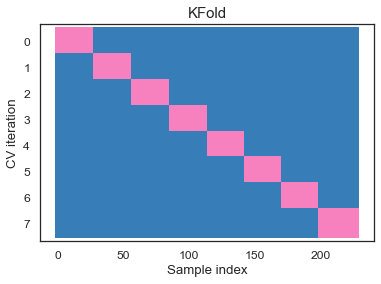

In [557]:
n_splits = 8
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, binned_spikes, ax, n_splits)

### Extra credit exercise 3: find the best decoder

Search across methods and hyperparameters for the best decoder. Try hyperopt, or random searches.

If you're fancy and have lots of compute time, maybe try automated ML. (e.g. autosklearn)


In [558]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [559]:
tuned_parameters = {}